# Import Data (replies already been excluded)

In [1]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords, wordnet
import pandas as pd

text = pd.read_csv('Jan6(excludes replies).csv')
print('The number of tweets (excludes replies) before data pre-processing:',len(text))

The number of tweets (excludes replies) before data pre-processing: 6501


In [2]:
import guidedlda

# Data Cleaning
1. tokenization
2. remove @users, hashtag symbols, Urls, and special symbols(i.e., '&amp'), non-alphabetic characters, and words that have less than 3 characters
3. remove stopwords
4. lowercase transformation
5. stemming

In [3]:
import gensim
import gensim.corpora as corpora
import re
porter = PorterStemmer()
stop_words = stopwords.words('english')
b = []
for i,u in text.iterrows():
    a = []
    word =''
    for words in str(u['tweets']).split(): #tokenization
        if '@' not in words: #remove @users
            words = words.replace('#','') #remove hashtag symbol
            if '#' not in words:
                if 'http' not in words: #remove URLs
                    if'&amp' not in words: #remove symbol
                        words = re.sub(r'[^a-zA-Z]', ' ', words)#remove non-alphabetic characters
                        if len(words)>2:
                            word += (words+' ')
    doc = ''
    for token in word.split():
        if len(token) >2: # remove words that have less than 3 characters
            token = token.lower()# lowercase form
            if token not in stop_words:# remove stopwords
                token = porter.stem(token) #stemming
                doc += (token+' ')
    b.append(doc)
text['processed']=[i for i in b]

# exclude tweets that are not in English
non_english_list = ['temiz','rkiy','erik','nda','konu','dan','da','ba','al','viand','para','na','dann','uft','laboratorio','dieser','kalbimi',
                   'restoranda','evento','komo','ind','tica','futuro','sonra','yla','cre','ili','daki',
                   'zaman']
index_axis = []
for index,i in text.iterrows():
    if len(i['processed']) == 0:
        index_axis.append(index)
    else:
        for word in i['processed'].split():
            if word in non_english_list:
                index_axis.append(index)
                break
text.drop(text.index[index_axis],inplace=True)
print("number of tweets after cleaning:",len(text))

number of tweets after cleaning: 6248


In [4]:
text.groupby('Company')['tweets'].count().sort_values(ascending=False)

Company
Memphis Meats       1545
biftek.co 🔬👩‍🔬🐄🥗    1429
Aleph Farms          704
Finless Foods        516
shiokmeats           463
SuperMeat            315
New Age Meats        306
BlueNalu             273
CUBIQ FOODS          243
Meatable             114
Mosa Meat            108
Wildtype              89
Future Fields         44
Vow                   36
FutureMeat            32
Balletic Foods        25
LabFarmFoods           2
Avant Meats            2
Mission Barns          2
Name: tweets, dtype: int64

# Randomly Select 20% Dataset As Our Training Set

In [5]:
text_random_20percent = text.sample(frac=0.2, random_state=2022)

In [6]:
text_random_20percent.groupby('Company')['tweets'].count().sort_values(ascending=False)

Company
Memphis Meats       319
biftek.co 🔬👩‍🔬🐄🥗    289
Aleph Farms         142
shiokmeats           88
Finless Foods        79
New Age Meats        70
SuperMeat            67
CUBIQ FOODS          48
BlueNalu             48
Mosa Meat            24
Meatable             23
Wildtype             16
FutureMeat           14
Vow                   9
Future Fields         7
Balletic Foods        6
Mission Barns         1
Name: tweets, dtype: int64

# Generate Bigrams

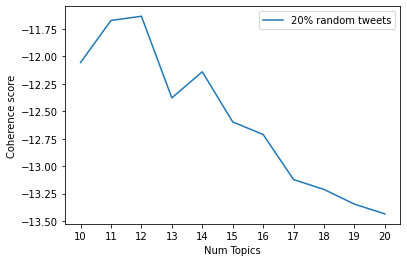

In [7]:
from gensim.models import CoherenceModel
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence),deacc=True)) #tokenization，return a list
data_words = list(sent_to_words(text_random_20percent['processed'])) #tokenization
bigram = gensim.models.Phrases(data_words,min_count=1,threshold=1)
'''mincount：int, the times that two unigram co-occur must be equal or higher than this number，
threshold：Phrases function will return a 'phrase score', it will decide whether two unigrams can be regarded as a bigram'''
bigram_mod = gensim.models.phrases.Phraser(bigram) # Bigram
def make_bigrams(texts): #Bigram
    return [bigram[doc] for doc in texts]
data_words_bigrams = make_bigrams(data_words)
id2word = corpora.Dictionary(data_words_bigrams)
texts = data_words_bigrams
corpus = [id2word.doc2bow(text) for text in texts]


def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start,limit,step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics,random_state=2022)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
limit=21; start=10; step=1
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=start, limit=limit, step=step)
# Show graph
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_values,label='20% random tweets')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(loc='best')
plt.xticks(range(start,limit,step))
plt.show()

According to the Coherence score **Umass**, we set the number of topics to **12**

In [8]:
print('The number of tweets in the training set:',len(texts))

The number of tweets in the training set: 1250


# Traditional Bigram LDA
print out the top 50 bigrams in each topic

In [9]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=12,random_state=2022,alpha='auto',per_word_topics=True)

amount =0
for idx, topic in lda_model.show_topics(formatted=False,num_topics=12,num_words= 500):
    print('\n',end='')
    print('Topic:',idx)
    num = 0
    for w in topic:
        if '_' in w[0] and num < 50:
            #print(round(w[1],4),'*',w[0],', ',end='',sep='')
            print('(',w[0],') ',end='',sep='')
            num += 1 
            amount+=1


Topic: 0
(plant_base) (cell_base) (meat_product) (anim_agricultur) (cultur_meat) (clean_meat) (cell_cultur) (fda_usda) (isra_startup) (grown_anim) (invest_clean) (food_product) (altprotein_cleanmeat) (step_toward) (aleph_farm) (food_foodtech) (global_food) (altern_protein) (grow_real) (smart_fat) (make_way) (path_market) (cellbas_meat) (plantbas_meat) (top_food) (could_futur) (invest_opportun) (startup_look) (good_news) (learn_lot) (meat_could) (food_secur) (food_tech) (new_book) (chef_culinari) (culturedmeat_innov) (want_work) (grow_anim) (solut_seafood) (take_time) (sustainablemeat_sustainablefood) (growth_medium) (demand_food) (quiz_trivia) (agricultur_get) (scale_product) (textur_key) (sound_like) (year_ago) (podcast_futur) 
Topic: 1
(aleph_farm) (cell_base) (grown_steak) (memphi_meat) (demo_day) (slaughter_free) (meat_product) (futur_meat) (santa_clara) (serv_world) (polish_dog) (meat_startup) (isra_startup) (meat_compani) (scienc_progress) (invest_cleanmeat) (anim_agricultur) (c

# GuidedLDA Model
latent topics are identified from the bigrams shown above.

In [10]:
bigramseed = [['foodtech','cellular','medium','stem','dprint','bioprint','cellag'],#0 Manufacturing process
             ['seafood','sushi','nigiri','fish','shrimp','crab','aquacultur',
              'lobster','salmon'],#1 Seafood
             ['steak','poultri','beef','chicken','duck'],#2 Meat product
             ['climat','chang','carbon','sustain','sustainablefood','sustainablemeat',
              'feed','serv','demand'],#3 Sustainibility
             ['altprotein','altern','protein','alt','plant','plantbas','vegan'],#4 Alternative protein
             ['slaughter','cruelti','harm','anim','kill','welfar'],#5 Animal welfare
             ['healthi','healthier','health','fat'],#6 Health and nutrition
             ['market','product','industri','suppli','chain','commerci'],#7 Industry and Market
             ['invest','startup','round','seed','fund','backer'],#8 Fundraising
             ['demo','event','speak','host','festiv','symposium','join','talk',
              'goodfoodconfer','watch','live','podcast','news','read','blog','post',
              'check','interview','articl','thank','announc','discuss'],#9 Public relations
             ['join','team','hire'],#10 Hiring information
             ['fda','usda','approv','advoc']]#11 Regulation

from sklearn.feature_extraction.text import CountVectorizer
import guidedlda
import numpy as np
model = guidedlda.GuidedLDA(n_topics=14,n_iter=1000,random_state=2022,refresh=10,alpha=0.01,eta=0.01)

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(text['processed'])

vocab = vectorizer.get_feature_names()
word2id = dict((v,idx) for idx,v in enumerate(vocab))
seed_topics = {}
for t_id, st in enumerate(bigramseed):
    for word in st:
        seed_topics[word2id[word]] = t_id

model.fit(X.toarray(),seed_topics=seed_topics,seed_confidence=0.7) #set seed confidence to 0.7
topic_word = model.topic_word_
n_top_words = 20
vocab = tuple(vocab)

for i, topic_dist in enumerate(topic_word): #Print out results
    print('\n')
    print('Topic:',i)
    words_probability = np.array(-topic_dist)
    for index in range(n_top_words):
        print(round(abs(np.sort(words_probability))[:(n_top_words)][index],4),'*',
              np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1][index],sep='',end='  ') 

INFO:guidedlda:n_documents: 6248
INFO:guidedlda:vocab_size: 7520
INFO:guidedlda:n_words: 74569
INFO:guidedlda:n_topics: 14
INFO:guidedlda:n_iter: 1000
INFO:guidedlda:<0> log likelihood: -978900
INFO:guidedlda:<10> log likelihood: -624493
INFO:guidedlda:<20> log likelihood: -610005
INFO:guidedlda:<30> log likelihood: -602178
INFO:guidedlda:<40> log likelihood: -598280
INFO:guidedlda:<50> log likelihood: -594905
INFO:guidedlda:<60> log likelihood: -592685
INFO:guidedlda:<70> log likelihood: -591103
INFO:guidedlda:<80> log likelihood: -589407
INFO:guidedlda:<90> log likelihood: -588374
INFO:guidedlda:<100> log likelihood: -587394
INFO:guidedlda:<110> log likelihood: -586658
INFO:guidedlda:<120> log likelihood: -586134
INFO:guidedlda:<130> log likelihood: -585331
INFO:guidedlda:<140> log likelihood: -584887
INFO:guidedlda:<150> log likelihood: -583957
INFO:guidedlda:<160> log likelihood: -583905
INFO:guidedlda:<170> log likelihood: -583959
INFO:guidedlda:<180> log likelihood: -583448
INFO:



Topic: 0
0.0472*cleanmeat  0.0334*culturedmeat  0.0164*foodtech  0.0148*cultivatedmeat  0.0148*cellular  0.0143*cellag  0.0133*futureoffood  0.0127*agricultur  0.009*innov  0.009*medium  0.009*protein  0.008*biftekco  0.0074*cellbasedmeat  0.0074*dprint  0.0069*beef  0.0069*farm  0.0069*bioprint  0.0069*present  0.0069*differ  0.0069*cellularagricultur  

Topic: 1
0.0309*seafood  0.0263*fish  0.0205*cell  0.0178*base  0.0173*singapor  0.0171*shrimp  0.0168*shiok  0.0161*salmon  0.0159*shiokmeat  0.0157*ocean  0.0136*sustain  0.0127*futureoffood  0.0111*asia  0.0104*sushi  0.0104*startup  0.0099*meat  0.0097*tast  0.0085*cellbasedmeat  0.0085*lobster  0.0078*cleanmeat  

Topic: 2
0.05*meat  0.0428*grown  0.0414*steak  0.0391*lab  0.0296*first  0.0229*cell  0.0187*chicken  0.0187*farm  0.0171*via  0.0162*world  0.015*cleanmeat  0.0144*aleph  0.0114*culturedmeat  0.0109*isra  0.0107*slaughter  0.0106*tast  0.0104*beef  0.0097*anim  0.009*cultur  0.009*startup  

Topic: 3
0.0263*food  0.

# Prominent Factor
For any tweet, let *t1* be the topic with the highest probability (*p1*) and the *t2* the next ranking topic (with probability *p2*), as determined by performing Guided LDA on the entire dadaset. We call the ratio of *p1*/*p2* the 'Prominent Factor' or PF. If *t1* is much more prominent than '*t2*', PF will be high. A factor higher than 1.4 means that one topic is relatively predominant for this tweet.

*References:*

Nugroho, Robertus, et al. "Incorporating tweet relationships into topic derivation." Conference of the Pacific Association for Computational Linguistics. Springer, Singapore, 2015.


In [11]:
prominent_factor = []
doc_topic = model.transform(X)
for i in range(len(doc_topic)):
    prominent_factor.append(sorted(doc_topic[i])[-1]/sorted(doc_topic[i])[-2])
count = 0
for i in prominent_factor:
    if i >= 1.4:
        count+=1
print('Prominent factor:',round(count/len(text)*100,2),'%',sep='')

/opt/anaconda3/lib/python3.7/site-packages/guidedlda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):


Prominent factor:81.56%


# Proportion of Each Topic

In [12]:
topic_number = []
number = []
topic_probability = []
for i in range(len(doc_topic)):
    topic_number.append(doc_topic[i].argmax())
    topic_probability.append(doc_topic[i][doc_topic[i].argmax()])
    number.append('1')
data = pd.DataFrame(data=[i for i in topic_number],columns=['topic_number'])
data['number'] = [i for i in number]
number_of_tweets = pd.DataFrame(data.groupby('topic_number')['number'].count())
number_of_tweets['proportion'] = [str(round(i/len(text)*100,2))+'%' for i in number_of_tweets['number']]
number_of_tweets['Topic'] = ['Manufacturing process','Seafood','Meat product','Sustainability',
                                 'Alternative protein','Animal welfare','Health and nutrition','Industry and market',
                                 'Fundraising','Event promotion and media release','Hiring information',
                                 'Regulation','Unseeded topic1','Unseeded topic2']
number_of_tweets

,number,proportion,Topic
topic_number,,,
0,173,2.77%,Manufacturing process
1,279,4.47%,Seafood
2,489,7.83%,Meat product
3,582,9.31%,Sustainability
4,406,6.5%,Alternative protein
5,691,11.06%,Animal welfare
6,235,3.76%,Health and nutrition
7,426,6.82%,Industry and market
8,526,8.42%,Fundraising


# Company-Topic Heatmap
Based on proportion of each topic for each company

/opt/anaconda3/lib/python3.7/site-packages/guidedlda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


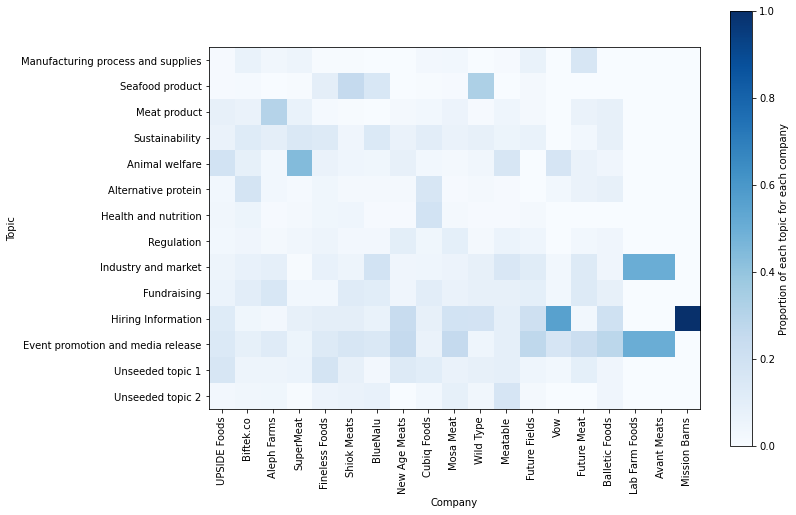

In [13]:
doc_topic = model.transform(X)
topic_number1 = []


for i in range(len(doc_topic)):
    topic_number1.append(doc_topic[i].argmax())
text['topic number'] = [i for i in topic_number1]
topic_author = text.groupby(['topic number','Company'])['tweets'].count()
topic_author_3d = topic_author.unstack()
topic_author_3d = topic_author_3d[['Memphis Meats','biftek.co 🔬👩‍🔬🐄🥗','Aleph Farms','SuperMeat',
                                  'Finless Foods','shiokmeats','BlueNalu','New Age Meats','CUBIQ FOODS',
                                  'Mosa Meat','Wildtype','Meatable','Future Fields','Vow',
                                  'FutureMeat','Balletic Foods','LabFarmFoods','Avant Meats','Mission Barns']]
topic = ['Manufacturing process and supplies','Seafood product','Meat product','Sustainability',
        'Animal welfare','Alternative protein','Health and nutrition','Regulation','Industry and market','Fundraising',
        'Hiring Information','Event promotion and media release','Unseeded topic 1','Unseeded topic 2']

company = ['UPSIDE Foods','Biftek.co','Aleph Farms','SuperMeat','Fineless Foods','Shiok Meats','BlueNalu',
          'New Age Meats','Cubiq Foods','Mosa Meat','Wild Type','Meatable','Future Fields','Vow','Future Meat',
           'Balletic Foods','Lab Farm Foods','Avant Meats','Mission Barns']
topic_author_3d = topic_author_3d.fillna(0)#replace NaN by 0
topic_author_3d = topic_author_3d.reindex([0,1,2,3,5,4,6,11,7,8,10,9,12,13])# reindex
import matplotlib.pyplot as plt
plt.figure(figsize=(11,8))
plt.imshow(topic_author_3d.div(topic_author_3d.sum(axis=0),axis=1),cmap="Blues")
plt.colorbar().ax.set_ylabel('Proportion of each topic for each company')
plt.xticks(range(len(company)), company,rotation=90)
plt.yticks(range(len(topic)), topic)
plt.xlabel('Company')
plt.ylabel('Topic')
plt.show()

# Traditional Unigram LDA

In [14]:
unigram = []
all_tweets = []
for i,tweet in text.iterrows():
    if len(unigram) != 0:
        all_tweets.append(unigram)
    unigram= []
    for word in tweet['processed'].split():
        unigram.append(str(word))
all_tweets.append(unigram)

In [15]:
unigram = []
unigram_list = []
for index, i in text.iterrows():
    unigram=[]
    for word in i['processed'].split():
        unigram.append(word)
    unigram_list.append(unigram)
data_words = [i for i in unigram_list]
id2word = corpora.Dictionary(data_words)
texts = data_words
corpus = [id2word.doc2bow(text) for text in texts]
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=14,random_state=2022,alpha=0.01,eta=0.01,per_word_topics=True)
lda_model.print_topics(num_words=20)

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(7520 unique tokens: ['base', 'becam', 'cell', 'cellag', 'cellbasedmeat']...) from 6248 documents (total 74569 corpus positions)
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online (single-pass) LDA training, 14 topics, 1 passes over the supplied corpus of 6248 documents, updating model once every 2000 documents, evaluating perplexity every 6248 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #2000/6248
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 6248 documents
INFO:gensim.models.ldamodel:topic #3 (0.010): 0.069*"meat" + 0.019*"food" + 0.014*"futur" + 0.013*"make" + 0.013*"via" + 0.013*"product" + 0.011*"sustain" + 0.011*"cultur" + 0.010*"anim" + 0.010*"compani"
INFO:gensim.models.ldamodel:

INFO:gensim.models.ldamodel:topic #7 (0.010): 0.034*"meat" + 0.023*"cleanmeat" + 0.023*"futurefood" + 0.018*"anim" + 0.018*"use" + 0.016*"cultivatedmeat" + 0.016*"food" + 0.015*"less" + 0.014*"plantbas" + 0.013*"cell" + 0.012*"protein" + 0.012*"muscl" + 0.011*"product" + 0.011*"grow" + 0.011*"opportun" + 0.011*"free" + 0.010*"public" + 0.010*"berkeley" + 0.009*"alt" + 0.009*"talk"
INFO:gensim.models.ldamodel:topic #8 (0.010): 0.025*"thank" + 0.019*"congratul" + 0.017*"scienc" + 0.016*"award" + 0.016*"meat" + 0.014*"agtech" + 0.014*"focu" + 0.013*"standard" + 0.010*"includ" + 0.010*"come" + 0.010*"gfi" + 0.009*"open" + 0.009*"end" + 0.009*"million" + 0.009*"coronaviru" + 0.009*"professor" + 0.009*"industri" + 0.009*"univers" + 0.008*"progress" + 0.008*"fight"
INFO:gensim.models.ldamodel:topic #9 (0.010): 0.044*"meat" + 0.033*"food" + 0.018*"futur" + 0.017*"cell" + 0.015*"protein" + 0.014*"join" + 0.014*"new" + 0.014*"base" + 0.014*"anim" + 0.013*"cultur" + 0.011*"dairi" + 0.010*"ceo" + 

[(0,
  '0.043*"cleanmeat" + 0.040*"steak" + 0.021*"foodtech" + 0.018*"cellag" + 0.017*"futureoffood" + 0.017*"cultivatedmeat" + 0.017*"world" + 0.016*"culturedmeat" + 0.016*"first" + 0.015*"farm" + 0.014*"cellbasedmeat" + 0.013*"cm" + 0.013*"biotech" + 0.012*"food" + 0.012*"via" + 0.012*"meat" + 0.011*"cellularagricultur" + 0.011*"make" + 0.011*"cell" + 0.011*"grown"'),
 (1,
  '0.052*"goodfoodconfer" + 0.033*"meat" + 0.025*"food" + 0.023*"plantbas" + 0.021*"billion" + 0.014*"get" + 0.012*"burger" + 0.011*"new" + 0.011*"sustain" + 0.010*"protein" + 0.010*"industri" + 0.010*"sept" + 0.010*"talk" + 0.009*"great" + 0.009*"impact" + 0.008*"anim" + 0.008*"see" + 0.008*"acceler" + 0.008*"futur" + 0.008*"action"'),
 (2,
  '0.037*"meat" + 0.024*"product" + 0.020*"sale" + 0.018*"lab" + 0.015*"grown" + 0.013*"like" + 0.013*"launch" + 0.012*"interview" + 0.012*"wrap" + 0.012*"cell" + 0.011*"space" + 0.011*"plant" + 0.010*"replac" + 0.010*"star" + 0.010*"cleanmeat" + 0.009*"cultiv" + 0.009*"protein

In [16]:
coherencemodel = CoherenceModel(model=lda_model, texts=unigram_list, dictionary=id2word, coherence='u_mass')
coherencemodel.get_coherence()

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 1000 documents
INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 2000 documents
INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 3000 documents
INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 4000 documents
INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 5000 documents
INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 6000 documents


-6.73612562449334

# Hellinger Distance:
![HD.png](HD.png)
# Entropy:
![Entropy.png](Entropy.png)

In [17]:
import math
def calculate_entropy(topic_word_distribution,num_of_topics):
    entropy = 0
    for topic in topic_word_distribution:
        for probability in topic:
            entropy -= probability*math.log(probability)
    return entropy/num_of_topics  
from gensim.matutils import hellinger
def calculate_hellinger_distance(topic_word,number_of_topics):
    distance = 0
    for i in range(0,number_of_topics-1):
        for j in range(i+1,number_of_topics):
            distance += hellinger(topic_word[i],topic_word[j])
    return distance*2/(number_of_topics*(number_of_topics-1))
def Evaluate(seedtopic,number_of_unseededtopic):
    number_of_topic = len(seedtopic)+number_of_unseededtopic #seeded topics + 2 unseeded topics
    model = guidedlda.GuidedLDA(n_topics=number_of_topic,n_iter=1000,random_state=2022,refresh=10,alpha=0.01,eta=0.01)#9 ok
    seed_topics = {}
    for t_id, st in enumerate(seedtopic):
        for word in st:
            seed_topics[word2id[word]] = t_id

    data_words = [i for i in all_tweets]
    id2word = corpora.Dictionary(data_words)
    from gensim.models import CoherenceModel
    model = model.fit(X.toarray(),seed_topics=seed_topics,seed_confidence=0.7)
    topic_word = model.topic_word_
    coherencemodel_guided_cv_seed4 = CoherenceModel(model=model, texts=all_tweets, dictionary=id2word, coherence='c_v')
    entropy_score = calculate_entropy(topic_word,number_of_topic)
    hellinger_distance = calculate_hellinger_distance(topic_word,number_of_topic)
    return coherencemodel_guided_cv_seed4.get_coherence() , entropy_score, hellinger_distance

In [18]:
Evaluate(bigramseed,2)

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(7520 unique tokens: ['base', 'becam', 'cell', 'cellag', 'cellbasedmeat']...) from 6248 documents (total 74569 corpus positions)
INFO:guidedlda:n_documents: 6248
INFO:guidedlda:vocab_size: 7520
INFO:guidedlda:n_words: 74569
INFO:guidedlda:n_topics: 14
INFO:guidedlda:n_iter: 1000
INFO:guidedlda:<0> log likelihood: -978900
INFO:guidedlda:<10> log likelihood: -624493
INFO:guidedlda:<20> log likelihood: -610005
INFO:guidedlda:<30> log likelihood: -602178
INFO:guidedlda:<40> log likelihood: -598280
INFO:guidedlda:<50> log likelihood: -594905
INFO:guidedlda:<60> log likelihood: -592685
INFO:guidedlda:<70> log likelihood: -591103
INFO:guidedlda:<80> log likelihood: -589407
INFO:guidedlda:<90> log likelihood: -588374
INFO:guidedlda:<100> log likelihood: -587394
INFO:guidedlda:<110> log likelihood: -586658
INFO:guidedlda:<120> log likelihood: -586134
INFO:guidedlda

(0.7881332790526823, 6.012459103383283, 0.8141072818656245)

In [19]:
lda_topics = lda_model.get_topics() #The topic-word distribution return by traditional LDA

In [20]:
calculate_entropy(lda_topics,14) #Calculate the entropy of the results of traditional LDA model

5.569550429546264

In [21]:
calculate_hellinger_distance(lda_topics,14) #Calculate the hellinger distance of the results of traditional LDA model

0.7084897920519022

In [22]:
#unigram
from gensim.models import CoherenceModel
unigram = []
unigram_list = []
for index, i in text.iterrows():
    unigram=[]
    for word in i['processed'].split():
        unigram.append(word)
    unigram_list.append(unigram)
data_words = [i for i in unigram_list]
id2word = corpora.Dictionary(data_words)
texts = data_words
corpus = [id2word.doc2bow(text) for text in texts]
'''def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start,limit,step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics,random_state=2022)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
#coherence score
limit=21; start=10; step=1
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=start, limit=limit, step=step)
# Show graph
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_values,label='All tweets')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(loc='best')
plt.show()'''

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(7520 unique tokens: ['base', 'becam', 'cell', 'cellag', 'cellbasedmeat']...) from 6248 documents (total 74569 corpus positions)


'def compute_coherence_values(dictionary, corpus, texts, limit, start, step):\n    coherence_values = []\n    model_list = []\n    for num_topics in range(start,limit,step):\n        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics,random_state=2022)\n        model_list.append(model)\n        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=\'c_v\')\n        coherence_values.append(coherencemodel.get_coherence())\n    return model_list, coherence_values\n#coherence score\nlimit=21; start=10; step=1\nmodel_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=start, limit=limit, step=step)\n# Show graph\nimport matplotlib.pyplot as plt\nx = range(start, limit, step)\nplt.plot(x, coherence_values,label=\'All tweets\')\nplt.xlabel("Num Topics")\nplt.ylabel("Coherence score")\nplt.legend(loc=\'best\')\nplt.show()'

In [23]:
CoherenceModel(model=lda_model, texts=all_tweets, dictionary=id2word, coherence='c_v').get_coherence()

INFO:gensim.topic_coherence.probability_estimation:using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
INFO:gensim.topic_coherence.text_analysis:serializing accumulator to return to master...
INFO:gensim.topic_coherence.text_analysis:serializing accumulator to return to master...
INFO:gensim.topic_coherence.text_analysis:serializing accumulator to return to master...
INFO:gensim.topic_coherence.text_analysis:serializing accumulator to return to master...
INFO:gensim.topic_coherence.text_analysis:serializing accumulator to return to master...
INFO:gensim.topic_coherence.text_analysis:accumulator serialized
INFO:gensim.topic_coherence.text_analysis:serializing accumulator to return to master...
INFO:gensim.topic_coherence.text_analysis:accumulator serialized
INFO:gensim.topic_coherence.text_analysis:serializing accumulator to return to master...
INFO:gensim.topic_coherence.text_analysis:accumulator serialized
INFO:gensim.topi

0.3497456953504089

## To export tweets within each topic:

text_topic0 = text2.loc[text2['most_salient_topic']== 0].sort_values('probability',ascending=False)
text_topic1 = text2.loc[text2['most_salient_topic']== 1].sort_values('probability',ascending=False)
text_topic2 = text2.loc[text2['most_salient_topic']== 2].sort_values('probability',ascending=False)
text_topic3 = text2.loc[text2['most_salient_topic']== 3].sort_values('probability',ascending=False)
text_topic4 = text2.loc[text2['most_salient_topic']== 4].sort_values('probability',ascending=False)
text_topic5 = text2.loc[text2['most_salient_topic']== 5].sort_values('probability',ascending=False)
text_topic6 = text2.loc[text2['most_salient_topic']== 6].sort_values('probability',ascending=False)
text_topic7 = text2.loc[text2['most_salient_topic']== 7].sort_values('probability',ascending=False)
text_topic8 = text2.loc[text2['most_salient_topic']== 8].sort_values('probability',ascending=False)
text_topic9 = text2.loc[text2['most_salient_topic']== 9].sort_values('probability',ascending=False)
text_topic10 = text2.loc[text2['most_salient_topic']== 10].sort_values('probability',ascending=False)
text_topic11 = text2.loc[text2['most_salient_topic']== 11].sort_values('probability',ascending=False)
text_topic12 = text2.loc[text2['most_salient_topic']== 12].sort_values('probability',ascending=False)
text_topic13 = text2.loc[text2['most_salient_topic']== 13].sort_values('probability',ascending=False)